## Dog Bites in New York City

### Data Exploration, Cleaning, and Preparation

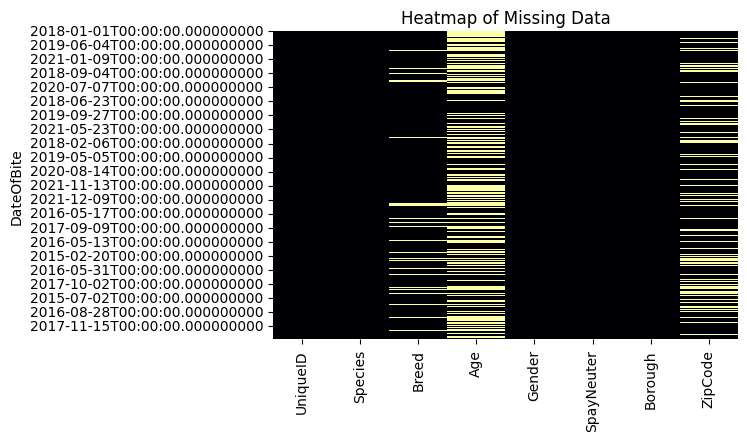

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.express as px
import json
import plotly.graph_objects as go

# for formatting
headline1 = "\n----------|"
headline2 = "|----------\n"

data = pd.read_csv("Dog_Bites_Data.csv")
data['DateOfBite'] = pd.to_datetime(data['DateOfBite'])
data.set_index('DateOfBite', inplace=True)

# heatmap of missing values
plt.figure(figsize=(6,4))
sns.heatmap(data.isnull(), cbar=False, cmap="inferno")
plt.title("Heatmap of Missing Data")
plt.show()

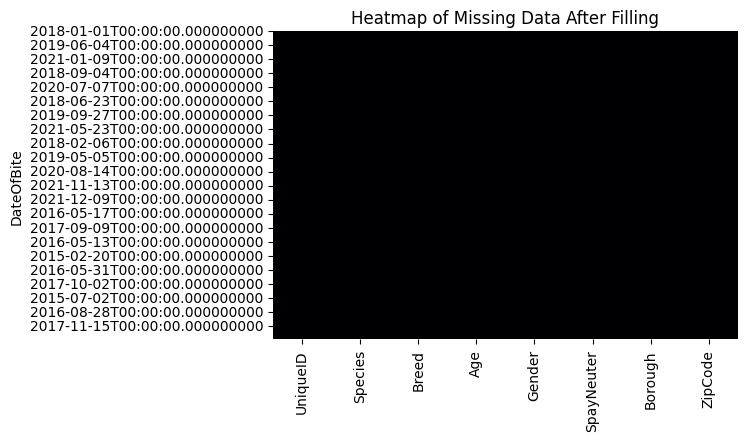

In [77]:
# fixing datatypes & filling missing values

# filling missing breeds with 'UNKNOWN'
data['Breed'] = data['Breed'].fillna('UNKNOWN')

# age to numeric
data['Age'] = pd.to_numeric(data['Age'], errors='coerce')

# fill missing age values with their median
data['Age'] = data['Age'].fillna(data['Age'].median())

# zipcode to numeric
data['ZipCode'] = pd.to_numeric(data['ZipCode'], errors='coerce')

# fill missing zip codes with 'UNKNOWN' to mirror Breed
data['ZipCode'] = data['ZipCode'].fillna('UNKNOWN')

# correcting unknown 'mixed' breeds into unknown to only keep known mixes
corrections = {
    "Mixed/Other": "UNKNOWN",
    "MIXED BREED": "UNKNOWN",
    "MIXED": "UNKNOWN"
}
data['Breed'] = data['Breed'].replace(corrections)

# heatmap of missing values (after filling)
plt.figure(figsize=(6,4))
sns.heatmap(data.isnull(), cbar=False, cmap="inferno")
plt.title("Heatmap of Missing Data After Filling")
plt.show()

In [78]:
# summary statistics of dataset

# to print datatypes
print(f"{headline1} Datatypes {headline2}{data.dtypes}")

# # of rows
print(f"{headline1} Rows {headline2}{len(data.axes[0])}")

# # of columns
print(f"{headline1} Columns {headline2}{len(data.axes[1])}")

# # of missing values
print(f"{headline1} Missing Data Count {headline2}{data.isnull().sum()}")

# for loop to go through each column and display numerical statistics or categorical statistics
for column in data.columns:
    if data[column].dtype == 'int64':
        print(f"{headline1} {column} {headline2}")
        print(f"median: {data[column].median()}") # median added to .describe since it was specified in project instructions
        print(data[column].describe())
    else:
        print(f"{headline1} {column} {headline2}")
        print(data[column].value_counts())



----------| Datatypes |----------
UniqueID        int64
Species        object
Breed          object
Age           float64
Gender         object
SpayNeuter       bool
Borough        object
ZipCode        object
dtype: object

----------| Rows |----------
22663

----------| Columns |----------
8

----------| Missing Data Count |----------
UniqueID      0
Species       0
Breed         0
Age           0
Gender        0
SpayNeuter    0
Borough       0
ZipCode       0
dtype: int64

----------| UniqueID |----------

median: 5666.0
count    22663.000000
mean      5715.036668
std       3354.278369
min          1.000000
25%       2833.500000
50%       5666.000000
75%       8499.000000
max      12383.000000
Name: UniqueID, dtype: float64

----------| Species |----------

Species
DOG    22663
Name: count, dtype: int64

----------| Breed |----------

Breed
UNKNOWN                              5865
Pit Bull                             4004
Shih Tzu                              731
Chihuahua        

In [79]:
data.head()

,UniqueID,Species,Breed,Age,Gender,SpayNeuter,Borough,ZipCode
DateOfBite,,,,,,,,
2018-01-01,1,DOG,UNKNOWN,4.0,U,False,Brooklyn,11220.0
2018-01-04,2,DOG,UNKNOWN,4.0,U,False,Brooklyn,UNKNOWN
2018-01-06,3,DOG,Pit Bull,4.0,U,False,Brooklyn,11224.0
2018-01-08,4,DOG,UNKNOWN,4.0,M,False,Brooklyn,11231.0
2018-01-09,5,DOG,Pit Bull,4.0,U,False,Brooklyn,11224.0


### Data Analysis & Maps

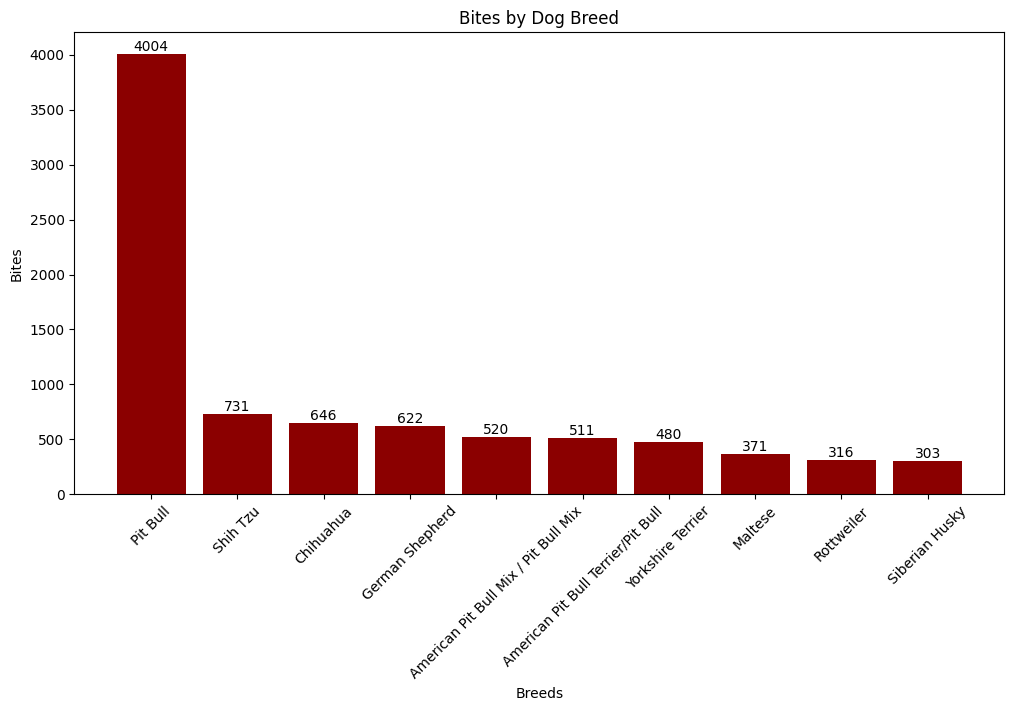

In [89]:
# getting the top ten breeds with most bites from dataset
grouped_breeds = data['Breed'].value_counts()   # grouping
grouped_breeds = grouped_breeds.iloc[1:]        # removing first row of 'UNKNOWN' breed
top_ten_breeds = grouped_breeds.head(10)        # keeping only the top ten

# converting to dataframe
top_ten_breeds = top_ten_breeds.reset_index()
top_ten_breeds.columns = ['Breed', 'Bites']

# plotting bar chart
plt.figure(figsize=(12,6))

# bar labels
bars = plt.bar(top_ten_breeds['Breed'], top_ten_breeds['Bites'], color='darkred')
for bar in bars:
    plt.text(
    bar.get_x() + bar.get_width() / 2, # X position: center of each bar 
    bar.get_height(), # Y position: height of each bar 
    bar.get_height(), # Text to display (the height of the bar) 
    ha='center', # Horizontal alignment 
    va='bottom' # Vertical alignment 
  )

plt.title("Bites by Dog Breed")
plt.xticks(rotation=45)
plt.xlabel('Breeds')
plt.ylabel('Bites')
plt.show()

In [128]:
# load geojson with nyc zip codes found online
with open("nyc_zipcodes.geojson") as f:
    ny_zip_json = json.load(f)

# filter out and retain only the valid nyc_zips from geojson
valid_nyc_zips = set(f['properties']['postalCode'] for f in ny_zip_json['features'])

# preprocess dog bites in nyc
zip_bite_counts = data['ZipCode'].value_counts().reset_index()
zip_bite_counts.columns = ['ZipCode', 'BiteCount']


############
# cleaning zip codes

# convert to string and remove .0 to normalize
zip_bite_counts['ZipCode'] = zip_bite_counts['ZipCode'].astype(str).str.replace('.0', '')

# remove any zip codes longer than 5 digits
zip_bite_counts = zip_bite_counts[zip_bite_counts['ZipCode'].str.len() <= 5]

# pad with leading zeros to ensure 5 digits
zip_bite_counts['ZipCode'] = zip_bite_counts['ZipCode'].str.zfill(5)

# keep only NYC zip codes
zip_bite_counts = zip_bite_counts[zip_bite_counts['ZipCode'].isin(valid_nyc_zips)]

############


color_scale = "YlOrRd"

# choropleth map
fig = px.choropleth(zip_bite_counts,
                    geojson=ny_zip_json,
                    locations='ZipCode',
                    featureidkey="properties.postalCode",
                    color='BiteCount',
                    color_continuous_scale=color_scale,
                    projection="mercator",
                    title="Dog Bites by NYC Zip Code"
)

# fit map on zipcodes and create space for centered title
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(
    margin={"r":0,"t":30,"l":0,"b":0},  # top margin for title
    title_x=0.5                         # centers title
)
fig.show()

In [127]:
#  bubble map
fig = px.scatter_geo(zip_bite_counts,
                     geojson=ny_zip_json,
                     locations='ZipCode',
                     featureidkey="properties.postalCode",
                     size='BiteCount',
                     size_max=30,
                     title='Dog Bites by NYC Zip Code',
                     projection='natural earth')


# fit map on zipcodes and create space for centered title
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(
    margin={"r":0,"t":30,"l":0,"b":0},  # top margin for title
    title_x=0.5                         # centers title
)
fig.show()